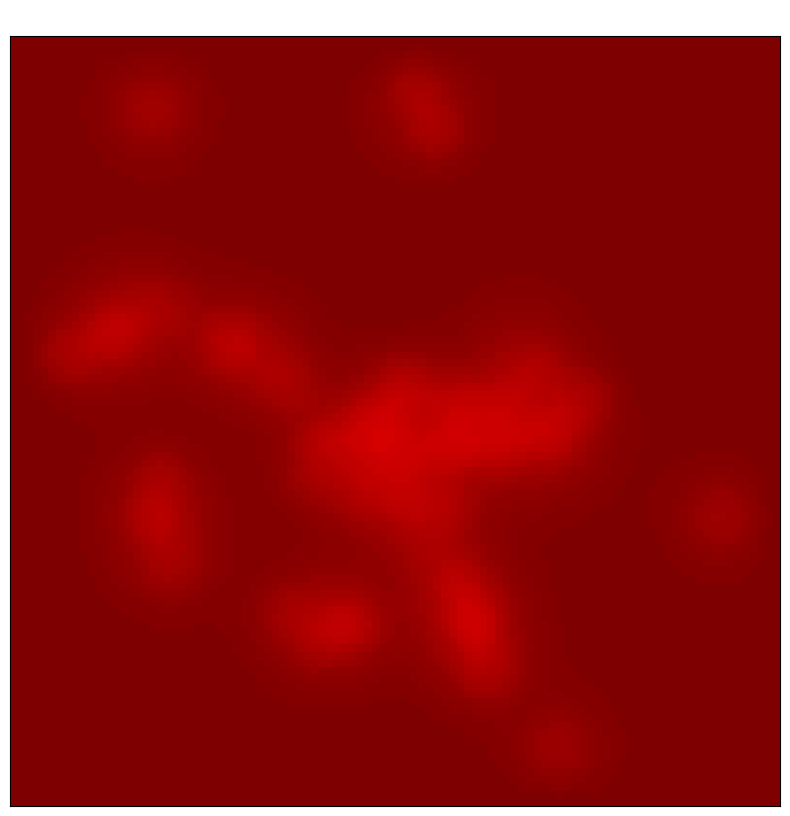

Saved visualization to main_step_500.png


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap

def load_data_for_step(output_dir, step_number):
    """Loads all saved data for a specific time step."""
    filename = os.path.join(output_dir, f"step_{step_number}.npz")
    if not os.path.exists(filename):
        print(f"Error: Data file not found for step {step_number} in {output_dir}")
        return None
    
    with np.load(filename) as data:
        # Create a dictionary from the loaded data for easy access
        return {key: data[key] for key in data.files}

def plot_simulation_state(data, step_number, plot_config, output_filename="visualization.png"):
    """
    Creates a multi-layered plot showing the full state of the simulation,
    with control over which layers are visible.
    """
    if data is None:
        return

    # Unpack data
    domain_size = data['nutrient_field'].shape

    # --- Create the Plot ---
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('black')
    ax.set_title(f"Simulation State at Step {step_number}", color='white', fontsize=16)
    ax.set_xticks([]); ax.set_yticks([])

    # --- Use plot_config to conditionally plot each layer ---

    # 1. Plot Nutrient Field (Base Layer)
    if plot_config.get('show_nutrient', False):
        nutrient_field = data['nutrient_field']
        ax.imshow(nutrient_field, cmap='jet', origin='lower', vmin=0, vmax=20, extent=[0, domain_size[1], 0, domain_size[0]])

    # 2. Plot Attractant Field (Overlay)
    if plot_config.get('show_attractant', False):
        attractant_field = data['attractant_field']
        colors = [(0, 1, 1, 0), (0, 1, 1, 1)] # Transparent to Cyan
        # attractant_cmap = LinearSegmentedColormap.from_list('transparent_cyan', colors, N=100)
        ax.imshow(attractant_field, cmap='jet', origin='lower', vmin=0, vmax=5, extent=[0, domain_size[1], 0, domain_size[0]])

    # 3. Plot Fluid Velocity (Streamlines)
    if plot_config.get('show_velocity', False):
        fluid_velocity = data['fluid_velocity']
        num_points = 20
        y_coords = np.linspace(0, domain_size[0] - 1, num_points)
        x_coords = np.linspace(0, domain_size[1] - 1, num_points)
        x, y = np.meshgrid(x_coords, y_coords)
        
        # Note the indexing for velocity components might need to be swapped (vy, vx)
        # depending on how the gradient was calculated in the simulation.
        vx = fluid_velocity[y.astype(int), x.astype(int), 0]
        vy = fluid_velocity[y.astype(int), x.astype(int), 1]
        # Plot velocity field using quiver instead of contourf
        ax.quiver(x, y, vx, vy, color='lightblue', scale=1e-1, width=0.003, headwidth=3)

    # 4. Plot Cells (Top Layer)
    if plot_config.get('show_cells', False):
        cell_positions = data['cell_positions']
        cell_radii = data['cell_radii']
        for i in range(len(cell_positions)):
            pos = cell_positions[i]
            rad = cell_radii[i]
            # Use a more visible color for cells on a potentially complex background
            circle = plt.Circle(pos, rad, color='lime', edgecolor='black', lw=0.5, fill=True, alpha=0.9)
            ax.add_artist(circle)
    
    ax.set_xlim(0, domain_size[1])
    ax.set_ylim(0, domain_size[0])
    plt.savefig(output_filename)
    plt.show()
    print(f"Saved visualization to {output_filename}")


if __name__ == '__main__':
    # --- USER CONFIGURATION ---
    # Specify which simulation run you want to visualize
    # Options: 'main', 'A1', 'A2', 'A3', 'Hydro_ON', 'Hydro_OFF'
    simulation_name = 'main'
    
    # Specify which time step you want to visualize
    # This must be a step you saved (e.g., 50, 100, 150, ...)
    step_to_visualize = 500

    # --- Control which layers to plot ---
    # Set any of these to False to hide that layer in the final plot.
    plot_config = {
        'show_nutrient': True,
        'show_attractant': False,
        'show_velocity': False,
        'show_cells': False,
    }
    # ----------------------------------------

    output_dir = f"simulation_data_{simulation_name}"
    
    # Load the data
    simulation_data = load_data_for_step(output_dir, step_to_visualize)
    
    # Create the plot
    if simulation_data:
        plot_simulation_state(
            simulation_data, 
            step_to_visualize, 
            plot_config, 
            f"{simulation_name}_step_{step_to_visualize}.png"
        )
